---

<h1><center>RUL Prediction of Nasa Turbofan Engine - Group 45 <br><br> FD001 Dataset </center></h1>

---

# 0. Background on the Dataset
WRITE STUFF HERE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng_seed = 2434 # Define seed for repeatability

# 1.1 Load Datasets and Append Target (RUL Series) to Datasets

In [3]:
# Column names from "Damage Propogation Modeling"
column_names = [
    'unit_number', 'time', 
    'altitude', 'machnum','tra',
    'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30',
    'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc',
    'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

# Load .txt files
raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yycji\AppData\Local\Temp\ipykernel_49740\3091788156.py:11: SyntaxWarning: invalid escape sequence '\s'
  raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
C:\Users\yycji\AppData\Local\Temp\ipykernel_49740\3091788156.py:12: SyntaxWarning: invalid escape sequence '\s'
  raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
C:\Users\yycji\AppData\Local\Temp\ipykernel_49740\3091788156.py:13: SyntaxWarning: invalid escape sequence '\s'
  true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


# 1.2 Compute and Append Target (RUL Series) to Datasets
In general, $RUL=t_{fail}-t$. However, since each unit in the datasets begins in a healthy state with constant sensor readings, a purely linear model resulted in poor model prediction. Ideally, changepoint detection would be implemented to identify the constant and linear regime of RUL but this is out of scope. instead, the same piecewise RUL function is used where:
$$
RUL = \begin{cases} 
      RUL_{max} & t_{fail}-t > RUL_{max} \\
      t_{fail}-t & t_{fail}-t \leq RUL_{max}
   \end{cases} 
$$
A coarse value for `RUL_MAX` was found by inspecting the graphs of various sensors in the training data. `RUL_MAX=105` was found by manually search (changing RUL_MAX until an approximate stationary point in the training score was found).

In [4]:
# Define the variable for the RUL ceiling
RUL_MAX = 105

# Calculate RUL series (target) for each unit ID in training data using failure time 'T_fail'
RUL_series = np.array([])
unique_units = raw_train['unit_number'].unique()
for unit_ID in unique_units:
    unit_data = raw_train[raw_train['unit_number'] == unit_ID].copy()
    T_fail = unit_data['time'].max() # Since training set is run-to-failure
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_train['RUL'] = RUL_series 

# Calculate RUL series for each Unit ID in test data using 'true_RUL'
RUL_series = np.array([])
for index, unit_ID in enumerate(unique_units):
    unit_data = raw_test[raw_test['unit_number'] == unit_ID].copy()
    
    T_last = unit_data['time'].max()
    RUL_last = true_RUL['RUL'][index]
    T_fail = T_last + RUL_last
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_test['RUL'] = RUL_series

# 1.3 Prune Test Data
We are only concerned with predicting RUL for the last cycle of each unit in test data since `RUL_FD001.txt` only gives the true RUL for the last cycle. Thus, all rows before the last cycle are removed.

In [5]:
raw_test = raw_test.groupby('unit_number').last().reset_index()

# 1.4 Inspect and Clean Datasets
Inspect and remove columns from `raw_train` and `raw_test` if they contain Null or NaN values. No such columns were found

In [6]:
# Make copy of data sets
clean_train = raw_train.copy()
clean_test = raw_test.copy()

# Identify if columns have null values
is_null_arr = pd.isnull(clean_train)
col_has_null = np.any(is_null_arr ,axis=0)
drop_null_cols = clean_train.columns[col_has_null]
clean_train.drop(drop_null_cols, axis=1)
clean_test.drop(drop_null_cols, axis=1)
drop_null_cols

Index([], dtype='object')

In [7]:
# Identify if columns have NaN values
is_nan_arr = pd.isna(clean_train)
col_has_nan = np.any(is_nan_arr, axis=0)
drop_nan_cols = clean_train.columns[col_has_nan]
clean_train.drop(drop_nan_cols, axis=1)
clean_test.drop(drop_nan_cols, axis=1)
drop_nan_cols

Index([], dtype='object')

# 1.5 Feature Selection and Defining Input and Output Dataframes
Features are removed based on two rudimentary criteria:
1. Features that are constant across all units are removed because they hold no statistical power
2. If 2 features are highly correlated, they are redundant and one may be removed
+ **Additionally:**
1. The `'unit_number'` feature is merely to partition the time series of different instances of simulated turbofan engines **within the same dataset** which have randomly generated starting healths (efficiency and flow parameters) and degradation trajectorys (parameters of an exponential degradation model) sampled from the same distributions. `'unit_number'=1` in `train_FD001.txt` and `test_FD001.txt` are **different instances** and should not be conflated. Thus, `unit_number` is removed from the datasets to prevent the models from biasing the predictions due to arbitrarily matching unit IDs.
2. The columns representing the operational settings are **known** to be held constant for `FD001` so they are removed

In [8]:
drop_cols = ['unit_number', 'altitude', 'machnum', 'tra'] # Remove settings columns

# Check which sensors have constant values across all units
unique_count_series = clean_train.nunique()
unique_count_series[unique_count_series == 1]

tra          1
T2           1
P2           1
epr          1
farB         1
Nf_dmd       1
PCNfR_dmd    1
dtype: int64

In [9]:
drop_cols += ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd'] # Remove useless sensors

# Identify feature pairs that have a abs(corr) higher than a threshhold
covariance_mat = clean_train.corr()
thresh = 0.95
highly_correlated_pairs = covariance_mat.stack().rename('Correlation')
highly_correlated_pairs = highly_correlated_pairs[abs(highly_correlated_pairs) >= thresh]
highly_correlated_pairs[highly_correlated_pairs != 1] # Remove pairs from diagonal entries

Nc   NRc    0.963157
NRc  Nc     0.963157
Name: Correlation, dtype: float64

In [10]:
drop_cols += ['NRc']

# Form feature and target matrices
Xtrain = clean_train.drop(drop_cols + ['RUL'], axis=1)
ytrain = clean_train['RUL']
Xtest = clean_test.drop(drop_cols + ['RUL'], axis=1)
ytest = clean_test['RUL']

# 2.1 Create Custom Scoring Function for GridSearchCV()
We will create a custom scorer for `GridSearchCV()` using the asymmetric scoring function presented in `"Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"` which takes the form: 
$$ s = \begin{cases} 
      \sum_{i=1}^{n}e^{-\frac{d}{10}}-1 & d<0 \\
      \sum_{i=1}^{n}e^{\frac{d}{13}}-1 & d\geq0 
   \end{cases} 
   \quad \text{where } d = \hat{y}-y
$$
This scoring function is used because it penalizes late predictions ($d\geq0$) more heavily than early predictions ($d<0$). Since the goal is to avoid failure entirely, this scoring metric is most suitable for our dataset. It is also the same scoring function used to evaluate submissisons for the Prognostics and Health Management competition that this dataset was originallly created for. A score of $s=0$ means perfect prediction and a negative score is not possible.

In [11]:
from sklearn.metrics import make_scorer

# define scoring function
def asymmetric_score(y,yhat):
    d = yhat-y
    early_pred_score = np.sum(np.exp(-d[d<0]/10)-1)
    late_pred_score = np.sum(np.exp(d[d>=0]/13)-1)
    score = early_pred_score + late_pred_score
    return score

# Make scoring function accesible to GridSearchCV()
my_scorer = make_scorer(asymmetric_score,greater_is_better=False)

# 2.2 Hyper Parameter Tuning With Gridsearch
Will use `hypersolve()` from lab06 to tune hyperparameters. `plot_grid_results()` from `lab6_utils.py` was modified to plot negative MSE instead of accuracy. 
+ **NOTE:** `scoring='neg_mean_squared_error'` and `refit='neg_mean_squared_error'` arguments passed to `GridSearchCV()` for regression models,

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lab6_utils import unpack_gridsearch, plot_grid_result

# Copied from Lab 06
def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=my_scorer, # pass custom scoring function
        cv=3,
        refit=True
    )
    
    # 3. Run the grid search
    gs = gs.fit(Xtrain,ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

# 3.1 Train Random Forest Regressor

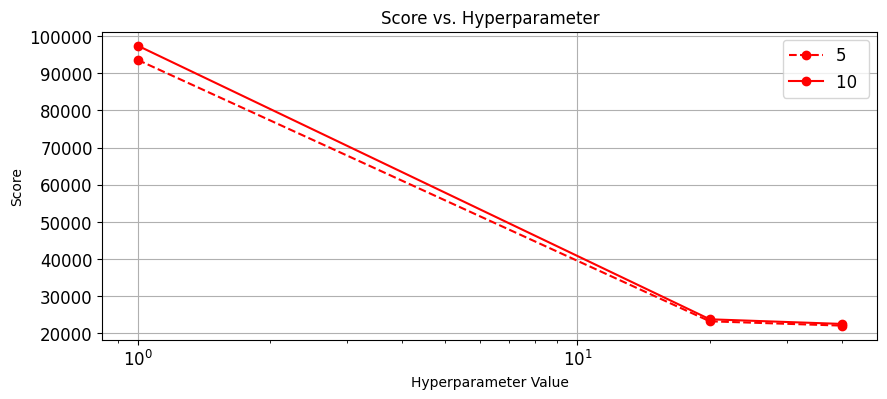

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define grid of viable hyper parameters
param_grid_rf = {
    'model__max_features' : [5, 10],#len(Xtrain.columns)],
    'model__n_estimators' : [1, 20, 40]
}

# Define an fit RF model
model = RandomForestRegressor(random_state=rng_seed)
result_rf = hypersolve(model, param_grid_rf)

In [14]:
result_rf

{'scoregrid': {5:     mean_test_score
  1      93582.929334
  20     23253.452802
  40     22089.694542,
  10:     mean_test_score
  1      97413.865278
  20     23792.753871
  40     22541.560555},
 'best_params': {'model__max_features': 5, 'model__n_estimators': 40},
 'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  RandomForestRegressor(max_features=5, n_estimators=40,
                                        random_state=2434))]),
 'best_score': 22089.694542156194,
 'param_grid': {'model__max_features': [5, 10],
  'model__n_estimators': [1, 20, 40]}}

# 3.2 Store Best Random Forest Model and Training Score

In [15]:
best_rf_model = result_rf['best_estimator']
rf_train_score = result_rf['best_score']
rf_train_score

22089.694542156194

# 3.3 Predict Test RUL With Best Random Forest Regressor and Store Test Score
**NOTE:** test score will be higher than training score because `clean_test` was pruned to only include the last time cycle of each unit

In [16]:
yhat = best_rf_model.predict(Xtest)
rf_test_score = asymmetric_score(true_RUL['RUL'],yhat)
rf_test_score

1158.5007471443496

# 3.4 Plot Random Forest Prediction
Plot predicted and true RUL for all the last cycle of all units in test dataset

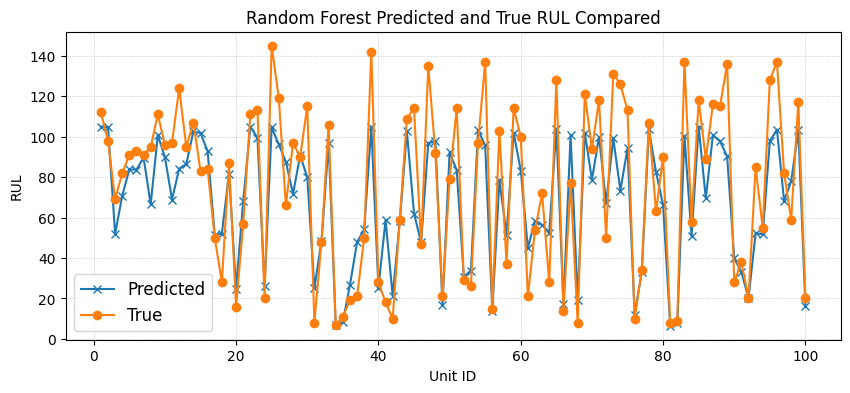

In [17]:
plt.figure(figsize=(10,4))
plt.plot(clean_test['unit_number'], yhat, label='Predicted', marker='x')
plt.plot(clean_test['unit_number'], true_RUL, label = 'True', marker='o')
    
plt.title('Random Forest Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

# 4.1 Linear Regression (Baseline Model)
As a simple linear baseline, we first standardize all input features using StandardScaler and then fit an ordinary least squares Linear Regression model. We evaluate the model using the asymmetric competition metric on both the training set and the test set (last cycle of each unit). This gives us a minimal performance reference

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale training and test data
scaler_lin = StandardScaler()
X_train_lin = scaler_lin.fit_transform(Xtrain)
X_test_lin  = scaler_lin.transform(Xtest)

# Fit baseline Linear Regression model
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train_lin, ytrain.values)

LinearRegression()

# 4.2 Evaluate Training Performance of Linear Regression Model


In [23]:
yhat_train_lin = lin_model.predict(X_train_lin)                    # Compute training predictions
lin_train_score = asymmetric_score(ytrain.values, yhat_train_lin)  # Compute asymmetric training score

print("Linear Regression training score (asymmetric):", lin_train_score)

Linear Regression training score (asymmetric): 89892.24214852745


# 4.3 Evaluate Test RUL with Linear Regression Model and Store Test Score

In [47]:
yhat_test_lin = lin_model.predict(X_test_lin)                     # Predict test set RUL
lin_test_score = asymmetric_score(true_RUL['RUL'].values, yhat_test_lin)    # Compute asymmetric test score

print("Linear Regression test score (asymmetric):", lin_test_score)

Linear Regression test score (asymmetric): 2198.856268055124


# 4.4 Plot Linear Regression Prediction


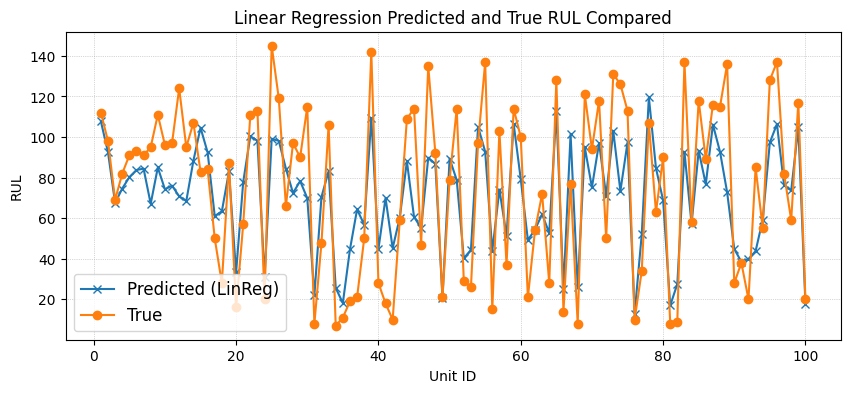

In [52]:
plt.figure(figsize=(10,4))
plt.plot(clean_test['unit_number'], yhat_test_lin, label='Predicted (LinReg)', marker='x')     # Predicted RUL (Linear Regression)
plt.plot(clean_test['unit_number'], true_RUL['RUL'],  label='True', marker='o')                # True RUL

plt.title('Linear Regression Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12, loc='lower left')

plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()


# 5.1 Train Multi-Layer Perception (MLP)


In [48]:
# NOTE:
# These pip install commands were only needed when initially setting up the
# notebook environment
# %pip install --upgrade pip
# %pip install "numpy<1.24"
# %pip install --upgrade tensorflow==2.19.0

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler

np.random.seed(rng_seed)      # numpy random seed
tf.random.set_seed(rng_seed)  # tensorflow global seed
# scaling
scaler_mlp = StandardScaler()
X_train_mlp = scaler_mlp.fit_transform(Xtrain)
X_test_mlp  = scaler_mlp.transform(Xtest)

y_train_mlp = ytrain.values
y_true_mlp  = true_RUL['RUL'].values

def build_mlp(h1, h2, h3, lr):
    D = X_train_mlp.shape[1]
    ki = GlorotUniform(seed=rng_seed)

    model = Sequential([
        Dense(h1, activation='relu', kernel_initializer=ki, input_shape=(D,)),
        Dense(h2, activation='relu', kernel_initializer=ki),
        Dense(h3, activation='relu', kernel_initializer=ki),
        Dense(1, activation='linear', kernel_initializer=ki),
    ])

    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss='mse'
    )
    return model

# Hyperparameter grid

grid_h1 = [32, 64]
grid_h2 = [16, 32]
grid_h3 = [8, 16]
grid_lr = [1e-3, 5e-4]

best_score = float("inf")
best_params = None
best_mlp_model = None

for h1 in grid_h1:
    for h2 in grid_h2:
        for h3 in grid_h3:
            for lr in grid_lr:

                model = build_mlp(h1, h2, h3, lr)

                model.fit(
                    X_train_mlp,
                    y_train_mlp,
                    epochs=20,
                    shuffle=False,     
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2
                )

                preds = model.predict(X_test_mlp).reshape(-1)
                score = asymmetric_score(y_true_mlp, preds)

                print(f"h1={h1}, h2={h2}, h3={h3}, lr={lr} → score={score}")

                if score < best_score:
                    best_score = score
                    best_params = (h1, h2, h3, lr)
                    best_mlp_model = model

print("Best score:", best_score)
print("Best params:", best_params)

C:\Users\yycji\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
h1=32, h2=16, h3=8, lr=0.001 → score=1646.2160595757402
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
h1=32, h2=16, h3=8, lr=0.0005 → score=12516.126315345306
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
h1=32, h2=16, h3=16, lr=0.001 → score=1627.5847299440302
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
h1=32, h2=16, h3=16, lr=0.0005 → score=3751.074024122561
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
h1=32, h2=32, h3=8, lr=0.001 → score=2387.6485399398707
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
h1=32, h2=32, h3=8, lr=0.0005 → score=6866.947056728127
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
h1=32, h2=32, h3=16, lr=0.001 → score=1616.055280404834
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
h1=32, h2=32, h3=16, lr=0.0005 → score=4582.392418555063
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
h1=64, h2=16, h3=8, lr=0.001 → score=1550.796182449659
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
h1=64, h2=16, h3=8, lr=0.0005 → score=4263.340783311648
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
h1=64, h2=16, h3=16

# 5.2 Evaluate Training Performance of Best MLP Model


In [56]:
# predict on training set
yhat_mlp_train = best_mlp_model.predict(X_train_mlp).reshape(-1)
# compute training score
mlp_train_score = asymmetric_score(y_train_mlp, yhat_mlp_train)

print("MLP Training Score (asymmetric):", mlp_train_score)


645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
MLP Training Score (asymmetric): 64156.23259523125


# 5.3 Evaluate Test RUL with Best MLP Model and Store Final Test Score

In [57]:
yhat_mlp_test = best_mlp_model.predict(X_test_mlp).reshape(-1)
mlp_test_score = asymmetric_score(y_true_mlp, yhat_mlp_test)

print("MLP Test Score (asymmetric):", mlp_test_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MLP Test Score (asymmetric): 1496.230030854333


# 5.4 Plot MLP Prediction



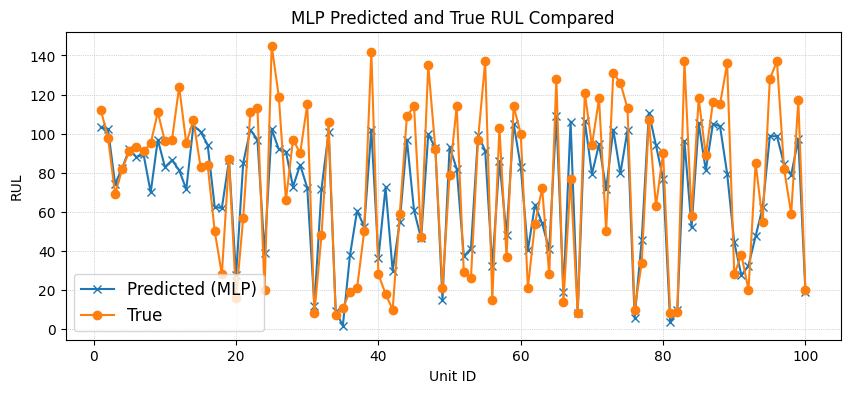

In [58]:
plt.figure(figsize=(10, 4))

plt.plot(clean_test['unit_number'], yhat_mlp_test, label='Predicted (MLP)', marker='x')
plt.plot(clean_test['unit_number'], true_RUL, label='True', marker='o')

plt.title('MLP Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12, loc='lower left')
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()
